# Fibroblast dataset exploration using scanpy

Here we explore the dataset Hs27-CRISPRa-TFs (https://zenodo.org/records/15200179) following the scanpy tutorial (https://scanpy.readthedocs.io/en/stable/tutorials/basics/clustering.html)

In [33]:
# Core scverse libraries (from https://virtualcellmodels.cziscience.com/quickstart/scgpt-quickstart)
from __future__ import annotations

# Data retrieval
import anndata as ad
import scanpy as sc

# Data processing
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

Checking what's inside the file.

In [34]:
# Set plotting parameters for Jupyter
sc.settings.verbosity = 3
sc.settings.set_figure_params(dpi=100, facecolor='white', figsize=(6, 4))
%matplotlib inline

# Load your data
adata = sc.read_h5ad('fibroblast_CRISPRa_final_pop_singlets_normalized_log1p.h5ad')

In [35]:
print(adata)

AnnData object with n_obs × n_vars = 220403 × 30395
    obs: 'dataset', 'UMI_count', 'guide_identity', 'guide_umi_count', 'thresholded_features', 'thresholded_guide_umi', 'num_cells', 'guide_target', 'gem_group', 'mt_frac', 'keep', 'single_cell', 'control', 'pairwise_coef', 'pairwise_UMI_count', 'pairwise_singlet_equivalent_UMI_count', 'final_pairwise_UMI_count', 'protospacer'
    var: 'gene_name', 'feature_types', 'genome', 'mean', 'in_matrix', 'std', 'cv', 'fano', 'pairwise_p_cost', 'mean_adjusted_pairwise_p_cost', 'excess_cv', 'pairwise_chosen'
    uns: 'log1p'
    layers: 'counts'


In [36]:
adata.layers

Layers with keys: counts

In [37]:
adata.var

,gene_name,feature_types,genome,mean,in_matrix,std,cv,fano,pairwise_p_cost,mean_adjusted_pairwise_p_cost,excess_cv,pairwise_chosen
gene_id,,,,,,,,,,,,
ENSG00000243485,MIR1302-2HG,Gene Expression,GRCh38,0.000011,True,0.003343,299.096558,0.999984,NaN,NaN,NaN,False
ENSG00000186092,OR4F5,Gene Expression,GRCh38,0.000013,True,0.003662,273.035431,0.999976,NaN,NaN,NaN,False
ENSG00000238009,AL627309.1,Gene Expression,GRCh38,0.000774,True,0.027792,35.928440,0.998511,NaN,NaN,NaN,False
ENSG00000239945,AL627309.3,Gene Expression,GRCh38,0.000038,True,0.006165,162.203262,0.999927,NaN,NaN,NaN,False
ENSG00000241860,AL627309.5,Gene Expression,GRCh38,0.002260,True,0.047677,21.093971,1.005699,NaN,NaN,NaN,False
...,...,...,...,...,...,...,...,...,...,...,...,...
ENSG00000276345,AC004556.3,Gene Expression,GRCh38,0.071618,True,0.272126,3.799665,1.033988,NaN,NaN,NaN,False
ENSG00000273554,AC136616.1,Gene Expression,GRCh38,0.000002,True,0.001495,668.805054,0.999998,NaN,NaN,NaN,False
ENSG00000278633,AC023491.2,Gene Expression,GRCh38,0.000007,True,0.002590,386.133148,0.999990,NaN,NaN,NaN,False


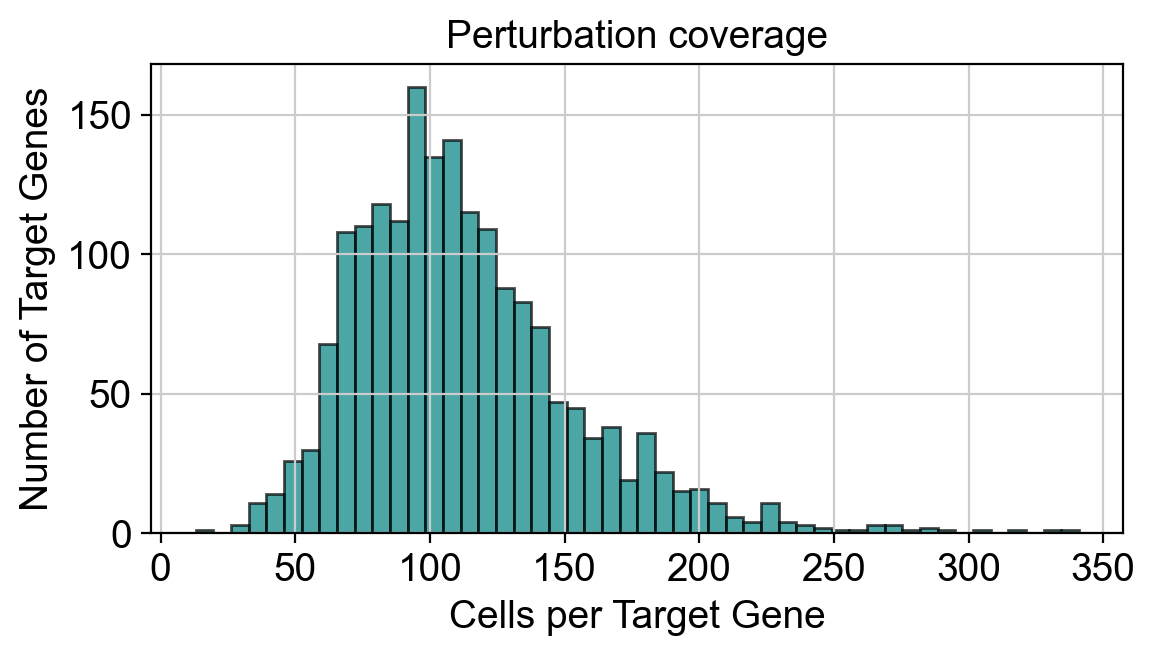

In [47]:
# Compute number of cells per target
cells_per_target = adata.obs["guide_target"].value_counts()

# Exclude control or non-targeting guides (common keywords)
cells_per_target_nc = cells_per_target[~cells_per_target.index.str.contains("non|NTC|ctrl|control", case=False)]

plt.figure(figsize=(6,3.5))
plt.hist(cells_per_target_nc.values, bins=50, color='teal', edgecolor='black', alpha=0.7)
#plt.axvline(cells_per_target_nc.median(), color='red', linestyle='--', label=f"Median: {cells_per_target_nc.median():.0f}")
#plt.xscale('log')
plt.xlabel("Cells per Target Gene")
plt.ylabel("Number of Target Genes")
plt.title("Perturbation coverage")
#plt.legend()
plt.tight_layout()
plt.show()

## Understanding the metadata

By design, a CRISPR activation assay assigns ~6 unique guides to the same gene. The redundancy comes from the need for replicates and to make sure that the gene is been perturbed, but it introduces a "perturbation level" effect, meaning that some genes might be more activated than others.

In [39]:
print(f"Total cells: {adata.n_obs:,}")
print(f"Total unique guides: {adata.obs['guide_identity'].nunique():,}")
print(f"Total unique target genes: {adata.obs['guide_target'].nunique():,}")
print(f"Control cells: {adata.obs['control'].sum():,} ({100*adata.obs['control'].sum()/adata.n_obs:.1f}%)")
print(f"Perturbed cells: {(~adata.obs['control']).sum():,} ({100*(~adata.obs['control']).sum()/adata.n_obs:.1f}%)")

Total cells: 220,403
Total unique guides: 10,924
Total unique target genes: 1,837
Control cells: 11,834 (5.4%)
Perturbed cells: 208,569 (94.6%)


In [40]:
# How many guides per target?
guides_per_target = adata.obs.groupby('guide_target')['guide_identity'].nunique().sort_values(ascending=False)
print(f"Average guides per target: {guides_per_target.mean():.2f}")
print(f"Median guides per target: {guides_per_target.median():.0f}")
print(f"Max guides per target: {guides_per_target.max()}")

print("\nTop 10 targets with most guides:")
print(guides_per_target.head(10))

Average guides per target: 5.95
Median guides per target: 6
Max guides per target: 78

Top 10 targets with most guides:
guide_target
non        78
TSC22D3     6
TWIST1      6
TULP4       6
TULP3       6
TULP2       6
TULP1       6
TUB         6
TTF1        6
TSHZ3       6
Name: guide_identity, dtype: int64


C:\Users\fbrit\AppData\Local\Temp\ipykernel_19380\1991980139.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  guides_per_target = adata.obs.groupby('guide_target')['guide_identity'].nunique().sort_values(ascending=False)


Each unique single guide RNA (sgRNA) in the CRISPR activation screen is represented in approximately 16 single cells on average. Since each target gene is typically assigned around six distinct sgRNAs, this results in roughly 100 perturbed cells per gene when aggregating across all its sgRNAs. In other words, each sgRNA serves as a technical replicate for the same gene perturbation, and together they provide a measure of both biological and technical variability in the activation strength of that target. The observed medians thus reflect the experimental coverage of perturbations across the dataset, where “cells per guide” indicates the replication depth per individual sgRNA, and “cells per target gene” captures the overall number of cells in which each gene was successfully perturbed.

C:\Users\fbrit\AppData\Local\Temp\ipykernel_19380\104888097.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  cells_per_guide = adata.obs.groupby("guide_identity").size().sort_values(ascending=False)
C:\Users\fbrit\AppData\Local\Temp\ipykernel_19380\104888097.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  cells_per_target = adata.obs.groupby("guide_target").size().sort_values(ascending=False)


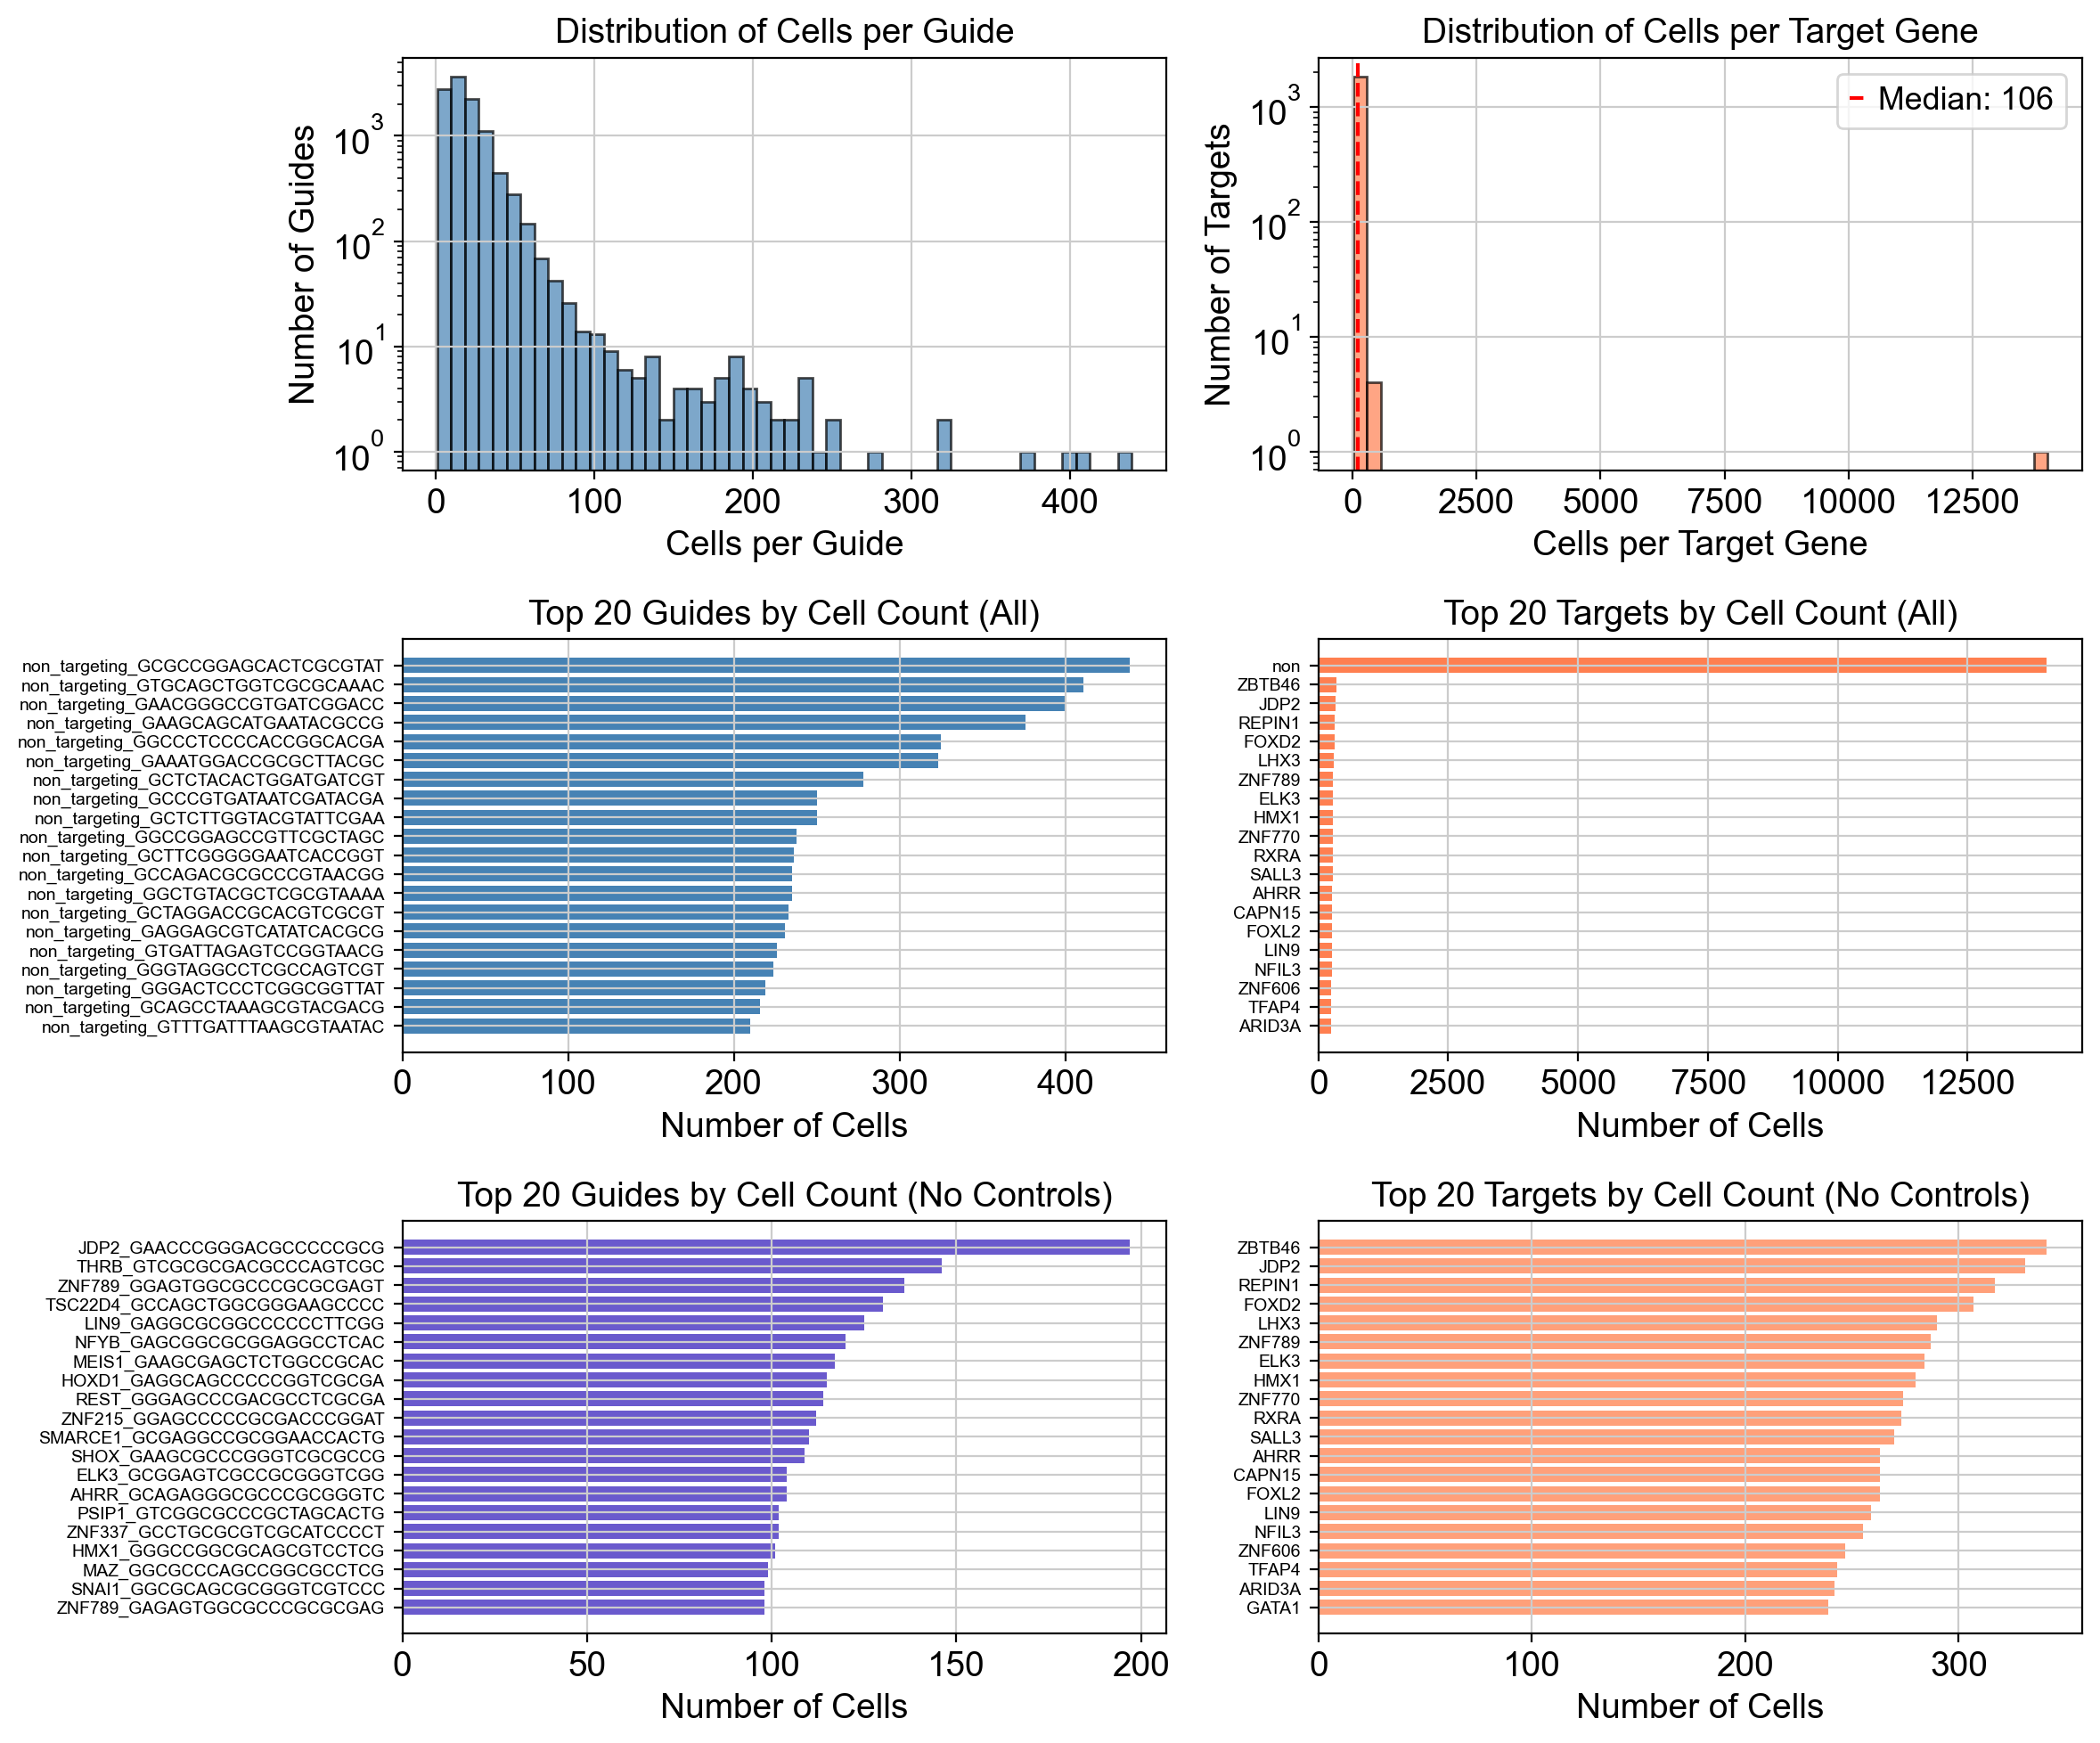

In [42]:
cells_per_guide = adata.obs.groupby("guide_identity").size().sort_values(ascending=False)
cells_per_target = adata.obs.groupby("guide_target").size().sort_values(ascending=False)

# Remove controls ("non", "NTC", etc.)
cells_per_guide_noctrl = cells_per_guide[~cells_per_guide.index.str.contains("non", case=False)]
cells_per_target_noctrl = cells_per_target[~cells_per_target.index.str.contains("non", case=False)]

# Figure layout
fig, axes = plt.subplots(3, 2, figsize=(12, 10))
fig.subplots_adjust(hspace=0.5, wspace=0.4)

# Cells per guide histogram
axes[0, 0].hist(cells_per_guide.values, bins=50, edgecolor='black', alpha=0.7, color='steelblue')
#axes[0, 0].axvline(cells_per_guide.median(), color='red', linestyle='--', label=f"Median: {cells_per_guide.median():.0f}")
axes[0, 0].set_xlabel("Cells per Guide")
axes[0, 0].set_ylabel("Number of Guides")
axes[0, 0].set_title("Distribution of Cells per Guide")
axes[0, 0].set_yscale("log")
#axes[0, 0].legend()

# Cells per target gene histogram (might not be useful!)
axes[0, 1].hist(cells_per_target.values, bins=50, edgecolor='black', alpha=0.7, color='coral')
axes[0, 1].axvline(cells_per_target.median(), color='red', linestyle='--', label=f"Median: {cells_per_target.median():.0f}")
axes[0, 1].set_xlabel("Cells per Target Gene")
axes[0, 1].set_ylabel("Number of Targets")
axes[0, 1].set_title("Distribution of Cells per Target Gene")
axes[0, 1].set_yscale("log")
axes[0, 1].legend()

# Top 20 guide sgRNAs
top_guides = cells_per_guide.head(20)
axes[1, 0].barh(range(len(top_guides)), top_guides.values, color='steelblue')
axes[1, 0].set_yticks(range(len(top_guides)))
axes[1, 0].set_yticklabels(top_guides.index, fontsize=7)
axes[1, 0].invert_yaxis()
axes[1, 0].set_xlabel("Number of Cells")
axes[1, 0].set_title("Top 20 Guides by Cell Count (All)")

# Top 20 target genes
top_targets = cells_per_target.head(20)
axes[1, 1].barh(range(len(top_targets)), top_targets.values, color='coral')
axes[1, 1].set_yticks(range(len(top_targets)))
axes[1, 1].set_yticklabels(top_targets.index, fontsize=7)
axes[1, 1].invert_yaxis()
axes[1, 1].set_xlabel("Number of Cells")
axes[1, 1].set_title("Top 20 Targets by Cell Count (All)")

# Top 20 guide sgRNAS (excluding controls)
top_guides_nc = cells_per_guide_noctrl.head(20)
axes[2, 0].barh(range(len(top_guides_nc)), top_guides_nc.values, color='slateblue')
axes[2, 0].set_yticks(range(len(top_guides_nc)))
axes[2, 0].set_yticklabels(top_guides_nc.index, fontsize=7)
axes[2, 0].invert_yaxis()
axes[2, 0].set_xlabel("Number of Cells")
axes[2, 0].set_title("Top 20 Guides by Cell Count (No Controls)")

# Top 20 target genes (exluding controls)
top_targets_nc = cells_per_target_noctrl.head(20)
axes[2, 1].barh(range(len(top_targets_nc)), top_targets_nc.values, color='lightsalmon')
axes[2, 1].set_yticks(range(len(top_targets_nc)))
axes[2, 1].set_yticklabels(top_targets_nc.index, fontsize=7)
axes[2, 1].invert_yaxis()
axes[2, 1].set_xlabel("Number of Cells")
axes[2, 1].set_title("Top 20 Targets by Cell Count (No Controls)")

plt.tight_layout()
plt.show()

Recall that `guide_identity` is the sgRNA, while `guide_target` is the gene that is been perturbed by the sgRNA. This is a many-to-one relationship as ~6 sgRNAs will target the same gene.

In [9]:
adata.obs.groupby('guide_identity').size()

C:\Users\fbrit\AppData\Local\Temp\ipykernel_19380\2227206345.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  adata.obs.groupby('guide_identity').size()


guide_identity
AATF_GCGCAGAAGGTTGAAGGGAT              14
AATF_GCGTGCGAGTGCGCGGGAAG               6
AATF_GGAAGGGATTGGAGCCGTAT              32
AATF_GGGCGTTGCTAGCATGAAGG              15
AATF_GTGAAGGGATTGGAGCCGTA              12
                                     ... 
non_targeting_GTTAAGGCACTCGTATGCGA    206
non_targeting_GTTCCTGTTGGGTCGCGAAT     77
non_targeting_GTTGATCGACCGATTGCGAT    121
non_targeting_GTTGTGATGTATCACGACTA    198
non_targeting_GTTTGATTTAAGCGTAATAC    210
Length: 10924, dtype: int64

In [10]:
# Coverage thresholds
thresholds = [10, 20, 50, 100, 200]
print("Guides with at least N cells:")
for thresh in thresholds:
    n_guides = (cells_per_guide >= thresh).sum()
    print(f"  ≥{thresh:3d} cells: {n_guides:5,} guides ({100*n_guides/len(cells_per_guide):.1f}%)")

print("\nTargets with at least N cells:")
for thresh in thresholds:
    n_targets = (cells_per_target >= thresh).sum()
    print(f"  ≥{thresh:3d} cells: {n_targets:5,} targets ({100*n_targets/len(cells_per_target):.1f}%)")

Guides with at least N cells:
  ≥ 10 cells: 8,168 guides (74.8%)
  ≥ 20 cells: 4,208 guides (38.5%)
  ≥ 50 cells:   495 guides (4.5%)
  ≥100 cells:    86 guides (0.8%)
  ≥200 cells:    22 guides (0.2%)

Targets with at least N cells:
  ≥ 10 cells: 1,837 targets (100.0%)
  ≥ 20 cells: 1,836 targets (99.9%)
  ≥ 50 cells: 1,792 targets (97.6%)
  ≥100 cells: 1,044 targets (56.8%)
  ≥200 cells:    67 targets (3.6%)


In [11]:
# Get non-control targets
perturbed_cells = adata[~adata.obs['control']]
unique_targets = perturbed_cells.obs['guide_target'].unique()
print(f"Total unique genes targeted: {len(unique_targets)}")

# Most and least covered targets
print(f"\nTop 20 most covered targets (by cell count):")
for i, (target, count) in enumerate(cells_per_target.head(20).items(), 1):
    n_guides = guides_per_target[target]
    print(f"{i:2d}. {target:20s}: {count:5,} cells, {n_guides:2d} guides")

print(f"\nBottom 20 least covered targets (by cell count):")
for i, (target, count) in enumerate(cells_per_target.tail(20).items(), 1):
    n_guides = guides_per_target[target]
    print(f"{i:2d}. {target:20s}: {count:5,} cells, {n_guides:2d} guides")

Total unique genes targeted: 1837

Top 20 most covered targets (by cell count):
 1. non                 : 14,013 cells, 78 guides
 2. ZBTB46              :   341 cells,  6 guides
 3. JDP2                :   331 cells,  6 guides
 4. REPIN1              :   317 cells,  6 guides
 5. FOXD2               :   307 cells,  6 guides
 6. LHX3                :   290 cells,  6 guides
 7. ZNF789              :   287 cells,  6 guides
 8. ELK3                :   284 cells,  6 guides
 9. HMX1                :   280 cells,  6 guides
10. ZNF770              :   274 cells,  6 guides
11. RXRA                :   273 cells,  6 guides
12. SALL3               :   270 cells,  6 guides
13. AHRR                :   263 cells,  6 guides
14. CAPN15              :   263 cells,  6 guides
15. FOXL2               :   263 cells,  6 guides
16. LIN9                :   259 cells,  6 guides
17. NFIL3               :   255 cells,  6 guides
18. ZNF606              :   247 cells,  6 guides
19. TFAP4               :   243 cells

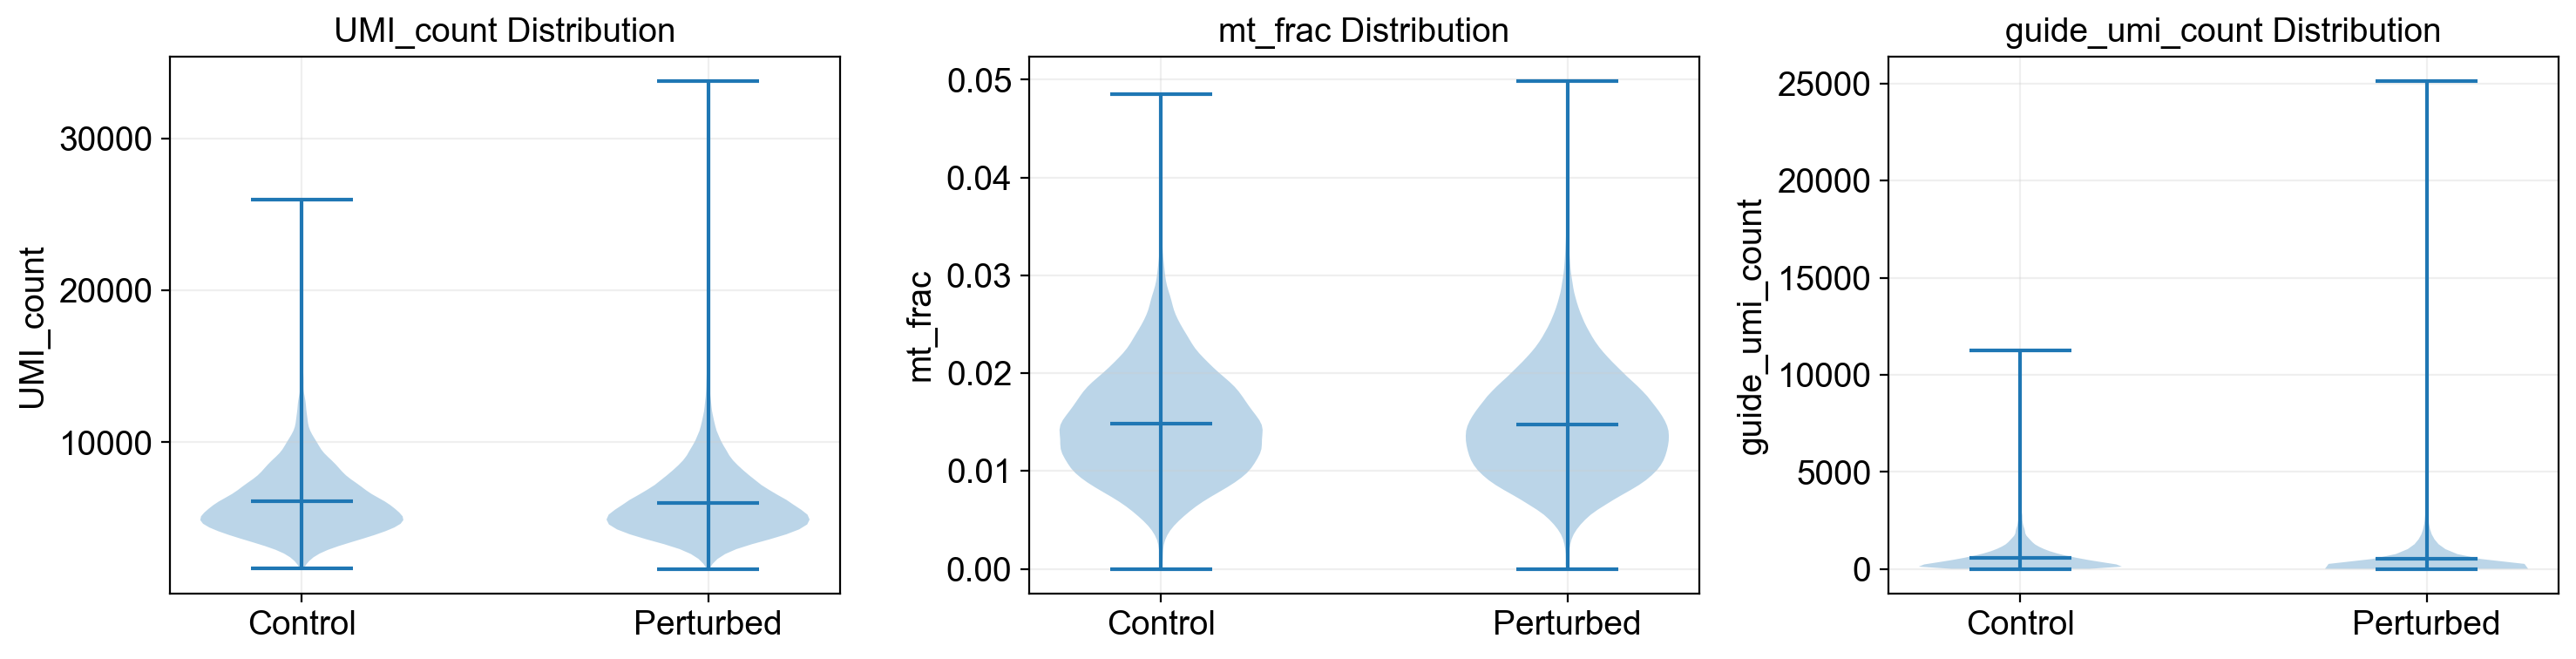

In [12]:
control_cells = adata[adata.obs['control']]
perturbed_cells = adata[~adata.obs['control']]

# Visualize
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
metrics = ['UMI_count', 'mt_frac', 'guide_umi_count']
for i, metric in enumerate(metrics):
    data_to_plot = [control_cells.obs[metric], perturbed_cells.obs[metric]]
    axes[i].violinplot(data_to_plot, positions=[0, 1], showmeans=True)
    axes[i].set_xticks([0, 1])
    axes[i].set_xticklabels(['Control', 'Perturbed'])
    axes[i].set_ylabel(metric)
    axes[i].set_title(f'{metric} Distribution')
    axes[i].grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

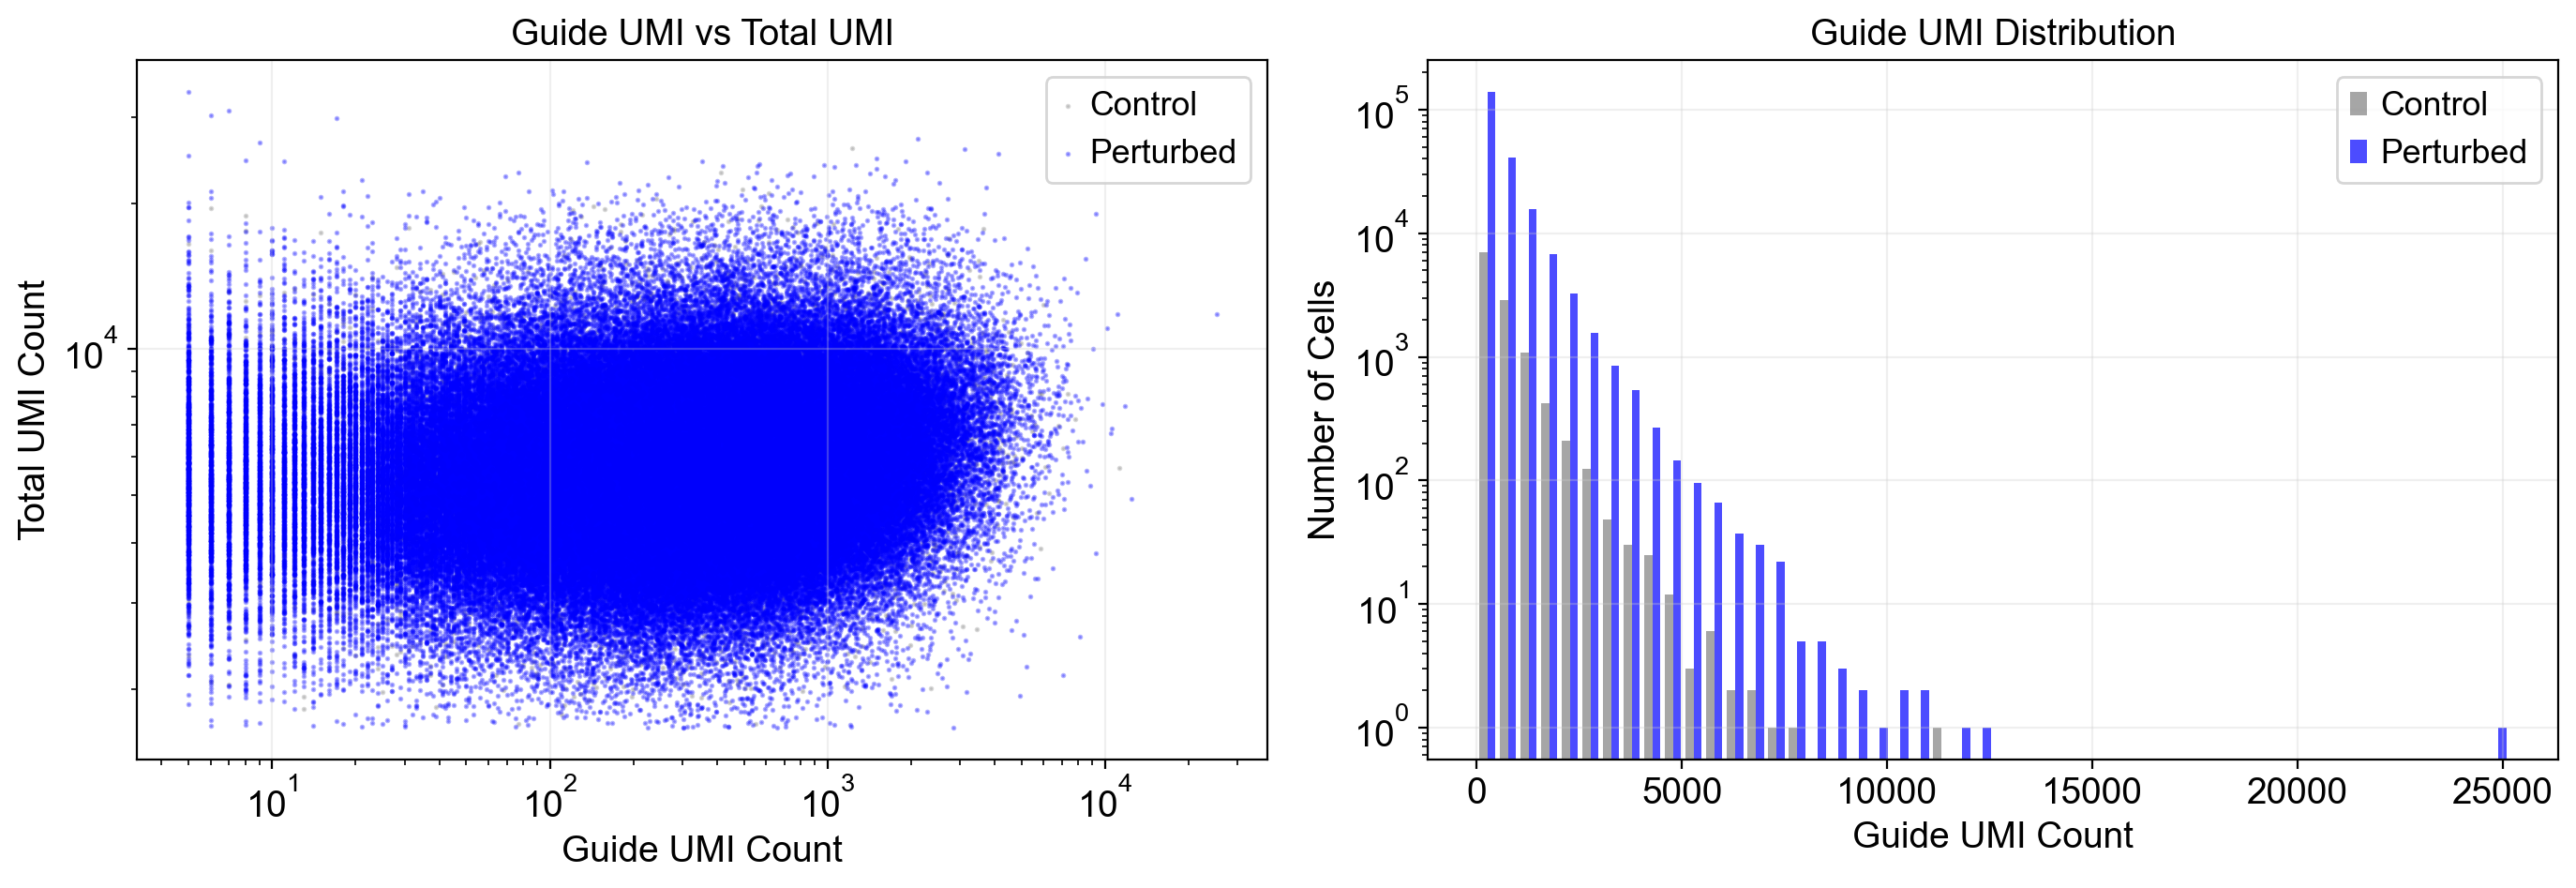

In [13]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 1. Scatter plot: Guide UMI vs Total UMI
axes[0].scatter(control_cells.obs['guide_umi_count'], control_cells.obs['UMI_count'],
                s=1, alpha=0.3, label='Control', color='gray')
axes[0].scatter(perturbed_cells.obs['guide_umi_count'], perturbed_cells.obs['UMI_count'],
                s=1, alpha=0.3, label='Perturbed', color='blue')
axes[0].set_xscale('log')
axes[0].set_yscale('log')
axes[0].set_xlabel('Guide UMI Count')
axes[0].set_ylabel('Total UMI Count')
axes[0].set_title('Guide UMI vs Total UMI')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# 2. Histogram: Guide UMI distribution
axes[1].hist([control_cells.obs['guide_umi_count'], perturbed_cells.obs['guide_umi_count']],
             bins=50, color=['gray','blue'], alpha=0.7, label=['Control','Perturbed'])
axes[1].set_yscale('log')
axes[1].set_xlabel('Guide UMI Count')
axes[1].set_ylabel('Number of Cells')
axes[1].set_title('Guide UMI Distribution')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()